# Image Classification with Naive Bayes

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf
import os
import csv

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.model_selection importRandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, precision_score, recall_score
from sklearn.naive_bayes import GaussianNB

2023-04-19 05:15:07.522415: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-19 05:15:07.741451: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-04-19 05:15:11.252291: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-04-19 05:15:11.252476: W tensorflow/strea

### Load Dataset

In [3]:
%%time

# Load the compressed array from disk
images_mini = np.load('CNN_Xs_downsample_forvgg16.npz')['data']

CPU times: user 11.5 s, sys: 4.25 s, total: 15.8 s
Wall time: 15.8 s


In [4]:
# load the labels from disk
with open('CNN_labels_downsampled_forvgg16.csv', 'r') as file:
    reader = csv.reader(file)
    labels_mini = list(reader)[0]
    labels_mini = [int(x) for x in labels_mini]
    y_mini= np.array(labels_mini)

In [5]:
print('images_mini.shape:', images_mini.shape)
print('\nnumber of labels:', len(labels_mini))
print('\nnumber of positive cancer cases:', sum(labels_mini))

images_mini.shape: (5600, 224, 224, 3)

number of labels: 5600

number of positive cancer cases: 600


### Normalize

In [6]:
print('Original max pixel value:', images_mini.max())
print('Confirm min pixel value is 0:', images_mini.min())

Original max pixel value: 255.0
Confirm min pixel value is 0: 0.0


In [7]:
#Normalize image pixel values
images_mini_norm = images_mini / images_mini.max() 

In [8]:
print('New max pixel value:', images_mini_norm.max())
print('Confirm min pixel value is 0:', images_mini_norm.min())

New max pixel value: 1.0
Confirm min pixel value is 0: 0.0


### Reshape

In [9]:
images_mini_norm.shape

(5600, 224, 224, 3)

In [10]:
arr_mean = np.mean(images_mini_norm, axis=-1)
arr_mean.shape
resized_images_mini = np.expand_dims(arr_mean, axis=-1)
resized_images_mini.shape

(5600, 224, 224, 1)

In [11]:
print('Original max pixel value:', resized_images_mini.max())
print('Confirm min pixel value is 0:', resized_images_mini.min())

Original max pixel value: 1.0
Confirm min pixel value is 0: 0.0


## Settings

In [12]:
random_state = 1234

In [13]:
random.seed(random_state)
tf.random.set_seed(random_state)
np.random.seed(random_state)

### Inputs

In [14]:
X= resized_images_mini
y = y_mini

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

# reshape
X_train = np.reshape(X_train, (len(X_train), -1))
X_test = np.reshape(X_test, (len(X_test), -1))

## Build Model

In [29]:
param_dist = {
    'var_smoothing': uniform(1e-4, 1e-1)
}

In [23]:
gnb_classifier = GaussianNB()

In [24]:
X_train.shape

(4480, 50176)

In [25]:
y_train.shape

(4480,)

In [30]:
grid_search = RandomizedSearchCV(
    gnb_classifier, 
    param_distributions=param_dist, 
    cv=StratifiedKFold(5),
    scoring='f1',
    n_jobs=10,
    verbose=20,
    n_iter=100,
    return_train_score=True,
)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=GaussianNB(), n_iter=20, n_jobs=10,
                   param_distributions={'var_smoothing': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7ff9b0962550>},
                   return_train_score=True, scoring='f1', verbose=20)

In [32]:
# print the best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Best Parameters: {'var_smoothing': 0.011289431757440382}
Best Score: 0.18994287361049236


In [ ]:
model_name = 'naivebayes'

# convert the results to a pandas DataFrame
cv_results = pd.DataFrame(grid_search.cv_results_)

# save the results to a CSV file
cv_results.to_csv(f'{model_name}_crossvalidation_results.csv', index=False)

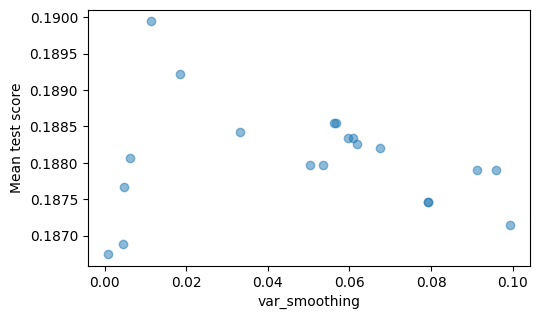

In [33]:
params = grid_search.cv_results_['params']
scores = grid_search.cv_results_['mean_test_score']


import seaborn as sns
for param_name in params[0].keys():
    # Extract the scores and hyperparameter values for the current parameter
    
    values = [pdict[param_name] for pdict in params]
    
    # Create a boxplot
    plt.figure()
    sns.boxplot(x=values, y=scores)
    plt.xlabel(param_name)
    plt.ylabel('f1_score')
    plt.show()

### Scoring

In [ ]:
grid_search.best_params_


{'var_smoothing': 7.771166283794724e-08}

In [34]:
hyperparameters = {'var_smoothing': 0.011289431757440382}

In [35]:
tuned_clf = GaussianNB(
    **hyperparameters
)

In [36]:
tuned_clf.fit(X_train, y_train)

GaussianNB(var_smoothing=0.011289431757440382)

In [37]:
train_roc = tuned_clf.score(X_train, y_train)
print(f"Train acc score: {train_roc:.3f}")

# Evaluate the test accuracy
test_roc = tuned_clf.score(X_test, y_test)
print(f"Test acc score: {test_roc:.3f}")

Train ROC_AUC score: 0.524
Test ROC_AUC score: 0.500


In [38]:
y_pred_train = tuned_clf.predict(X_train)
y_pred_test = tuned_clf.predict(X_test)

NameError: name 'confusion_matrix' is not defined

In [39]:
train_roc = roc_auc_score(y_train, y_pred_train)
print(f"Train ROC_AUC score: {train_roc:.3f}")

# Evaluate the test accuracy
test_roc = roc_auc_score(y_test, y_pred_test)
print(f"Test ROC_AUC score: {test_roc:.3f}")

Train ROC_AUC score: 0.530
Test ROC_AUC score: 0.524


In [40]:
train_roc = precision_score(y_train, y_pred_train)
print(f"Train precision score: {train_roc:.3f}")

# Evaluate the test accuracy
test_roc = precision_score(y_test, y_pred_test)
print(f"Test precision score: {test_roc:.3f}")


Train precision score: 0.119
Test precision score: 0.115
Train recall score: 0.536
Test recall score: 0.555


In [ ]:
train_roc = recall_score(y_train, y_pred_train)
print(f"Train recall score: {train_roc:.3f}")

# Evaluate the test accuracy
test_roc = recall_score(y_test, y_pred_test)
print(f"Test recall score: {test_roc:.3f}")

In [41]:
from sklearn.metrics import f1_score
train_roc = f1_score(y_train, y_pred_train)
print(f"Train f1 score: {train_roc:.3f}")

# Evaluate the test accuracy
test_roc = f1_score(y_test, y_pred_test)
print(f"Test f1 score: {test_roc:.3f}")

Train f1 score: 0.195
Test f1 score: 0.191
[CV 2/5; 2/20] START var_smoothing=6.321087710398318e-08........................
[CV 2/5; 2/20] END var_smoothing=6.321087710398318e-08;, score=(train=0.221, test=0.213) total time=   3.4s
[CV 5/5; 3/20] START var_smoothing=4.477277390071145e-08........................
[CV 5/5; 3/20] END var_smoothing=4.477277390071145e-08;, score=(train=0.201, test=0.172) total time=   3.0s
[CV 2/5; 5/20] START var_smoothing=7.899758081188034e-08........................
[CV 2/5; 5/20] END var_smoothing=7.899758081188034e-08;, score=(train=0.221, test=0.213) total time=   3.1s
[CV 2/5; 7/20] START var_smoothing=2.8646425514309668e-08.......................
[CV 2/5; 7/20] END var_smoothing=2.8646425514309668e-08;, score=(train=0.221, test=0.213) total time=   4.8s
[CV 4/5; 9/20] START var_smoothing=9.681393536837051e-08........................
[CV 4/5; 9/20] END var_smoothing=9.681393536837051e-08;, score=(train=0.195, test=0.194) total time=   4.0s
[CV 4/5; 11

In [ ]:

cm = confusion_matrix(y_test, y_pred_test)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=tuned_clf.classes_
)
disp.plot()
plt.show()